In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

C:\Users\mateo\AppData\Local\Temp\ipykernel_10476\1941916579.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2021-01-01", end="2025-07-29")  # Especificamos el rango de fechas
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2021-01-04  126.239700  130.336805  123.654619  130.249014  143301900
2021-01-05  127.800499  128.512626  125.283702  125.732440   97664900
2021-01-06  123.498543  127.839531  123.283931  124.591108  155088000
2021-01-07  127.712700  128.405313  124.727667  125.215418  109578200
2021-01-08  128.815002  129.380795  127.039582  129.185683  105158200


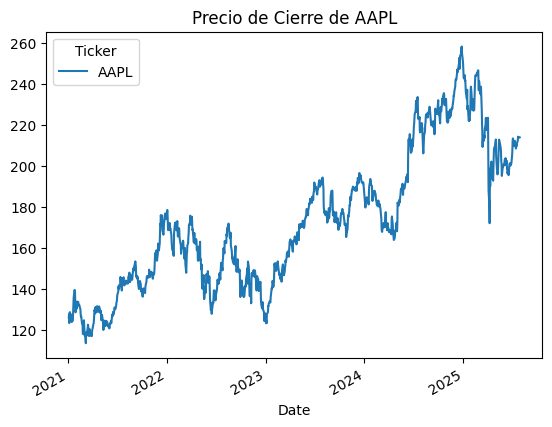

In [31]:
# 1. Especificar el ticker de la acción
ticker = 'AAPL'  # Aquí puedes poner el ticker que desees, por ejemplo, AAPL para Apple

# 2. Descargar los precios históricos usando yfinance
data = yf.download(ticker, start="2021-01-01", end="2025-07-29")  # Especificamos el rango de fechas

# 3. Visualizar los primeros registros
print(data.head())

# 4. Opcional: Graficar los precios de cierre
import matplotlib.pyplot as plt

data['Close'].plot(title=f"Precio de Cierre de {ticker}")
plt.show()

In [32]:
#Vemos la estructura de los datos, durante el ultimo año
data[data.index>'2025-01-01'].head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-01-02,243.263199,248.500565,241.238085,248.330961,55740700
2025-01-03,242.774368,243.592387,241.307905,242.774368,40244100
2025-01-06,244.410416,246.734810,242.614744,243.722074,45045600
2025-01-07,241.627136,244.959095,240.769205,242.395272,40856000
2025-01-08,242.115936,243.123515,239.472320,241.337815,37628900


1. Vamos a emplear para el analisis los precios ajustados al cierre. 
Estos precios son mas realistas, pues consideran la reparticion de dividendos, splits, consolidaciones comporativas etc

# Definicion del Movimiento Browniano Geometrico

Se ha demostrado matematicamente que el comportamiento de las acciones se puede modelar con un MBG.

$$dS(t) = \mu S(t) dt + \sigma S(t) dB(t)$$

donde:
- $S(t)$ es el precio en el tiempo $t$,
- $\mu$ es la tasa de crecimiento esperada,
- $\sigma$ es la volatilidad,
- $B(t)$ es un proceso de Wiener, tambien conocido como ruido aleatorio.

La solución de esta ecuación es:

$$S(t+1) = S(t) \exp\left(\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma B(t)\right)$$



1. Para calcular $\mu$ en primer lugar debemos calcular los retornos logaritmicos para cada momento $t$

$$rt=ln\left(\frac{st}{st-1}\right)$$

In [33]:
data['retornos']=(data['Close'] / data['Close'].shift(1)).apply(lambda x: np.log(x))
data.head()

Price,Close,High,Low,Open,Volume,retornos
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,
Date,,,,,,
2021-01-04,126.239700,130.336805,123.654619,130.249014,143301900,NaN
2021-01-05,127.800499,128.512626,125.283702,125.732440,97664900,0.012288
2021-01-06,123.498543,127.839531,123.283931,124.591108,155088000,-0.034241
2021-01-07,127.712700,128.405313,124.727667,125.215418,109578200,0.033554
2021-01-08,128.815002,129.380795,127.039582,129.185683,105158200,0.008594


2. Calculamos la tasa de crecimiento esperada

$$\mu=\frac{1}{N}\sum_{t=1}^{n} rt$$

In [34]:
#Metodo 1
N=len(data)-1 #Menos 1 porque el primer elemento no tiene retorno
mu=data['retornos'].sum()/N
print('el parametro mu del modelo es: ', mu)

el parametro mu del modelo es:  0.00046115909490407385


In [35]:
#Metodo 2
data['retornos'].mean()

0.00046115909490407385

3. Calculamos la volatilidad $\sigma$

$$\sigma = \sqrt{\frac{1}{N-1} \sum_{t=1}^{N} \left( r_t - \mu \right)^2}$$





In [36]:
#Metodo 1
N = len(data['retornos']) -1 # Número total de retornos
sigma = np.sqrt(np.sum((data['retornos'] - mu)**2) / (N - 1))
print('el parametro sigma del modelo es: ', sigma)

el parametro sigma del modelo es:  0.017779768311255297


In [37]:
#Metodo 2
sigma = data['retornos'].std()
sigma

0.017779768311255297

3. Definimos el proceso estocastico asi:

$$st+1=st*EXP\left[\left(\mu -\frac{\sigma^2}{2}\right)dt+\sigma et \sqrt{dt}\right]\$$

donde,

- dt es 1/252 dias de mercado \newline
- et es un numero aleatorio de una distribucion N(0,1)
- st retorno en el momento t
- st+1 retorno en el momento t+1

In [45]:
#Procedemos a crear una funcion que modele el proceso estocastico
def MGB_acciones(mu,sigma,data,col_name,steps):

    #Los parametros de la funcion son:
    #mu -> Tasa de crecimiento esperada
    #sigma -> volatilidad del activo
    #data -> pandas df que contiene los retornos logaritmicos del activo en dias
    #col_name -> nombre de la columna de los retornos
    #steps -> numero de pasos hacia adelante en el proceso estocastico

    dt=1/252 # son solo 252 dias de traiding en el año.
    s0=data['Close'].iloc[-1].iat[0] #Tomamos el ultimo elemento de los precios, ya que este sera el punto de partida
    et_vector=np.random.normal(loc=0, scale=1, size=steps) # Vector de numeros aletorios de media 0 y desviacion estandar 1
    exp_vector = np.exp((mu - (sigma**2) / 2) * dt + sigma * et_vector * np.sqrt(dt))

    st_1=[]

    for i in range(0,steps):

        if i==0:
            s=s0*exp_vector[0]
        else:
            s=st_1[i-1]*exp_vector[i]

        st_1.append(s)
            

    return st_1

#Probamos la funcion
#MGB_acciones(mu, sigma, data, 'Adj Close',252)

In [63]:
Montecarlo_results.iloc[:, 0]

0      214.038642
1      213.633547
2      214.166585
3      214.294677
4      214.004424
          ...    
247    210.854773
248    210.868537
249    210.683648
250    210.879676
251    211.038327
Name: sim_0, Length: 252, dtype: float64

In [46]:
# Funcion que realiza graficos de lineas
def lineas_multiples(data, title='Gráfico de Múltiples Líneas', xlabel='Eje X', ylabel='Eje Y'):
    """
    Función para graficar múltiples líneas con colores aleatorios.
    
    Parámetros:
    - data: DataFrame de pandas con los datos a graficar.
    - title: Título del gráfico.
    - xlabel: Etiqueta del eje X.
    - ylabel: Etiqueta del eje Y.
    """
    plt.figure(figsize=(10, 6))  # Tamaño de la figura
    num_lines = data.shape[1]  # Número de líneas (columnas en el DataFrame)
    
    # Generar un color aleatorio para cada línea
    colors = np.random.rand(num_lines, 3)  # Colores aleatorios en RGB

    for i in range(num_lines):
        plt.plot(np.arange(1, data.shape[0] + 1), data.iloc[:, i], color=colors[i], label=f'Línea {i + 1}')  # Acceso corregido
    
    # Configurar título y etiquetas
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Mostrar la cuadrícula
    plt.grid(True)
    
    # Mostrar leyenda
    #plt.legend()
    
    # Mostrar el gráfico
    plt.show()

In [74]:
simulations = []
for i in range(sim):
    s = pd.Series(MGB_acciones(mu, sigma, data, 'Close', 252))
    s.name = f'sim_{i}'
    simulations.append(s)

Montecarlo_results = pd.concat(simulations, axis=1)

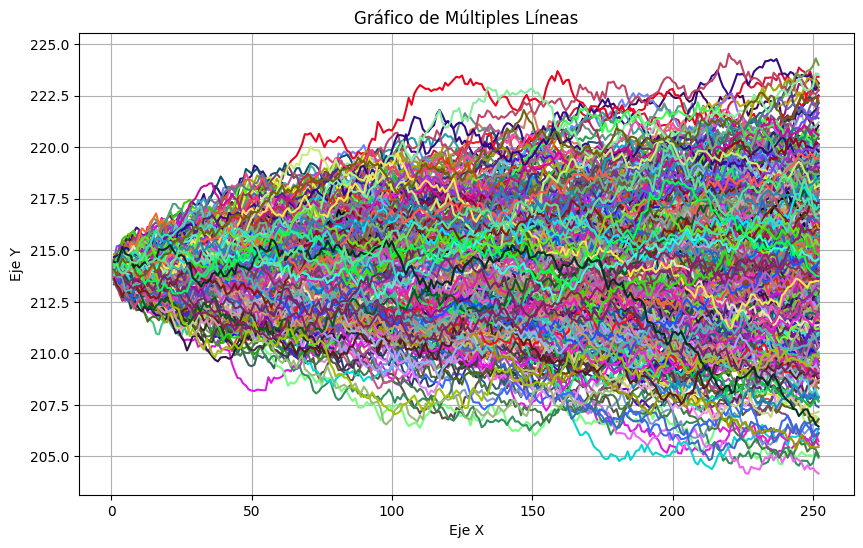

In [75]:
#Graficamos
lineas_multiples(Montecarlo_results, title='Gráfico de Múltiples Líneas', xlabel='Eje X', ylabel='Eje Y')

In [76]:
#Calculamos la probabilidad de perder 5% de la inversion inicial en el próximo año
alfa=0.05
s0=data['Close'].iloc[-1].iat[0]
print('El precio de compra es: ', s0)

El precio de compra es:  214.0500030517578


In [77]:
Montecarlo_results.tail()

,sim_0,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,sim_7,sim_8,sim_9,...,sim_490,sim_491,sim_492,sim_493,sim_494,sim_495,sim_496,sim_497,sim_498,sim_499
247,215.054353,216.226082,214.110354,208.817611,211.912230,213.833045,212.260337,221.457513,214.575657,210.067285,...,215.780841,208.995528,216.016952,219.532413,218.191820,214.178946,217.529814,222.152511,207.284272,218.024070
248,215.275890,216.088746,213.803117,208.500562,211.606855,213.726216,212.534004,221.223728,214.306766,209.806940,...,215.650362,209.266271,215.944556,219.686995,218.181896,214.030473,217.196413,222.336986,206.959333,217.827553
249,215.449295,216.159572,213.679148,208.774234,211.777884,213.671660,212.875829,221.191971,214.882530,209.630136,...,215.211455,209.112030,215.751831,219.631977,218.244644,213.910629,217.103578,222.289548,206.861239,217.071322
250,215.579810,216.139934,213.796607,208.434214,211.836800,213.605639,212.788840,220.785521,215.279819,209.622441,...,215.420715,209.003737,216.001064,219.409193,218.433624,213.775327,216.983841,222.481013,206.555343,216.615213
251,215.109045,216.231189,213.487516,208.309315,211.548067,213.881259,212.724259,221.058390,214.887944,209.775157,...,215.262640,209.041457,216.002335,219.464953,218.508299,213.753835,217.146377,222.138724,206.459481,216.557394


In [78]:
precios_cierre = Montecarlo_results.iloc[-1,:] #Seleccionamos los precios finales a un año de inversion
precios_cierre

sim_0      215.109045
sim_1      216.231189
sim_2      213.487516
sim_3      208.309315
sim_4      211.548067
              ...    
sim_495    213.753835
sim_496    217.146377
sim_497    222.138724
sim_498    206.459481
sim_499    216.557394
Name: 251, Length: 500, dtype: float64

In [79]:
total=len(precios_cierre)
exito=len(precios_cierre[precios_cierre<(s0*(1-alfa))])

p=exito/total

print(p*100,'%')

0.0 %
